In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats, special
import sys
import config
plt.style.use('ggplot')
import os
import time
import datetime
from matplotlib import rc
import plot_cluster_utils as pcu
import figure_utils 
rc('text', usetex=True)
SMALL_SIZE=15
MEDIUM_SIZE=25
rc('legend', fontsize=SMALL_SIZE)
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)

import numpy as np
from numba import jit
from scipy import stats
import time
import matplotlib.pyplot as plt
from matplotlib import animation

from numpy import trapz

plt.style.use("ggplot")

In [2]:
@jit
def conditional_prob(xt,sigma,tau,K,xrange,delta_t):
    
    mu = xt + (xt/tau*(1-xt/K) * delta_t)
    std = np.sqrt(sigma/tau) * xt * np.sqrt(delta_t)
    
    cond_prob = []
    
    for xval in xrange:
        cond_prob.append((1/std)*np.exp(-1/2*((xval - mu)/std)**2))
    
    return(cond_prob)
    
#@jit
def matrix_power_table(date_diff_set,Y):
    
    YT_dic = {1:Y}
    num = 1
    for diff in date_diff_set:
        YT_temp = YT_dic[num]
        #num = diff + num
        YT_dic[diff] = np.linalg.matrix_power(YT_temp,diff)
    return YT_dic


def make_markov_matrix(sigma,tau,K,xrange,delta_t):
    Y = []
    for xt in xrange:
        y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)
     
    for i in range(Y.shape[0]):
    
        Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
        Y[i] = Y[i]*xrange_diff
        Y[i] = Y[i,:]/sum(Y[i,:])
    
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
    return(Y)


def sim_SLM_MC(YT_dic,x0,xrange):
    
    diffarr = np.abs(xrange - x0) 
    X = [xrange[np.argwhere(diffarr == min(diffarr))[0][0]]]    
    
    for i in strain_total_freqs["Order"][:-1]:
        date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
        Yt = YT_dic[date_diff]
        x = X[-1]
        diffarr = np.abs(xrange - x) 
        argw = np.argwhere(diffarr == min(diffarr))[0][0]
        
        X.append(np.random.choice(xrange,p=Yt[argw]))
        
    return X

We'd like to write down a model for strain dynamics of the following type:

$$x(t+\delta t) = x(t) + \frac{x(t)}{\tau_i}\left(1 - \frac{x(t)}{K}\right)\delta t + \sqrt{\frac{\sigma}{\tau}}x(t)Z_t \delta t $$ 

where $Z_t$ is an independent standard Gaussian

$$ \rho (x(t+\delta t) | x(t) ) = N \left( x(t) + \frac{x(t)}{\tau} \left( 1 - \frac{x(t)}{K} \right)\delta t, \sqrt{\frac{\sigma}{\tau}} x(t) \delta t \right)$$

At the moment, am coarse-graining at $\Delta t = 30$ minutes. Can I come up with a technical argument in terms of a microscopic model for why this makes sense? 

In [7]:
species = "Bacteroides_fragilis_54507"
#species = "Faecalibacterium_prausnitzii_61481"
host = "am"
strain_total_freqs = pcu.get_strain_total_freqs(species,host)

#sra = pd.read_csv("metadata/Poyet_SRA_report.txt",sep="\t",index_col=3)
#samps = sra["read_count"].loc[strain_total_freqs.index]
#samps = samps[samps > 1e6]
#strain_total_freqs = strain_total_freqs.loc[samps.index]

/u/home/r/rwolff/diversity_ecology/scripts/plot_cluster_utils.py:28: RuntimeWarning: invalid value encountered in true_divide
  freqs[list(snp_map[key])[1]].append(np.array(list(snp_map[key])[2]/list(snp_map[key][3])))
/u/home/r/rwolff/diversity_ecology/scripts/plot_cluster_utils.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strain_df["Date_Diffs"][0] = 0.0


In [8]:
strain_total_freqs[3] = strain_total_freqs[1] + strain_total_freqs[2]

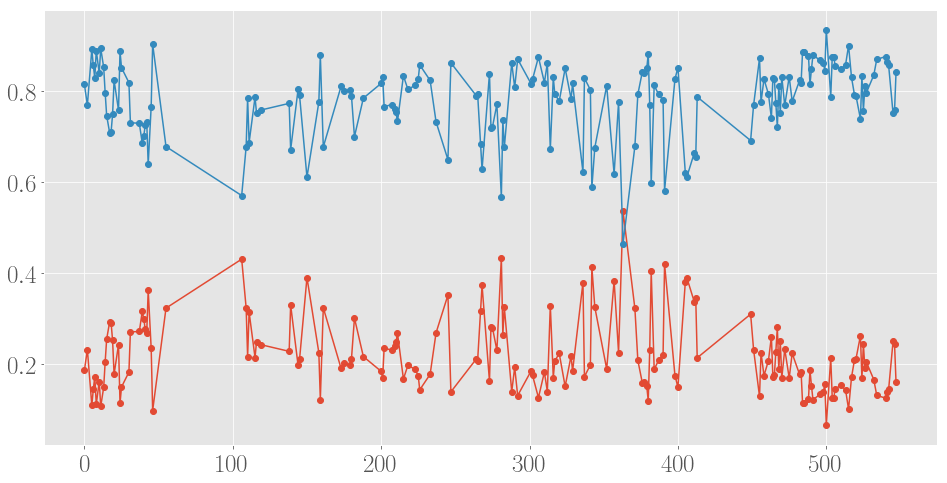

In [10]:
plt.figure(figsize=(16,8))
plt.plot(times,list(strain_total_freqs[1]/strain_total_freqs[3]),"o-")
plt.plot(times,list(strain_total_freqs[2]/strain_total_freqs[3]),"o-")
#plt.semilogy()
#plt.ylim([0,1])

In [6]:
np.corrcoef(list(strain_total_freqs[1]),list(strain_total_freqs[2]))

array([[1.        , 0.60845136],
       [0.60845136, 1.        ]])

In [ ]:
beta = (strain_total_freqs[4].mean()/strain_total_freqs[4].std())**2
sigma = 2/(beta+1)

In [ ]:
sigma

In [4]:
strain = 1
#sigma = (2/(1/.17+1))**2
#sigma = .56**.5
#sigma = 0.2948303412538197
#sigma = 0.40486724722627987
beta = (strain_total_freqs[strain].mean()/strain_total_freqs[strain].std())**2
sigma = (2/(beta+1))
times = np.cumsum(strain_total_freqs["Date_Diffs"])
#num_days = 50
#day_num = np.argmin(np.abs(list(times - num_days)))
#day_num = int(strain_total_freqs[strain].shape[0]/3)

#beta = (strain_total_freqs[strain].mean()/strain_total_freqs[strain].std())**2
#sigma = 2/(beta+1)

N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))
#K = sum(strain_total_freqs[strain]*strain_total_freqs["Date_Diffs"])/N
K = np.mean(strain_total_freqs[strain])
K = K/(1-sigma/2)

dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])

delta_t = 1/24

tau_list = np.linspace(.2,5,10)

bin_list = []


#xrange = np.logspace(np.log10(.1*min(strain_total_freqs[1])),np.log10(10*max(strain_total_freqs[1])),500)
#xrange = np.linspace(0,1,500)
xrange = np.logspace(np.log10(1e-5),np.log10(1),999)
#xrange = np.insert(xrange,0,np.logspace(np.log10(1e-12),np.log10(1e-6),20))
xrange_diff = (xrange[1:] - xrange[:-1])
xrange_diff = np.insert(xrange_diff,0,0)
#xrange = xrange[1:]

for elem in strain_total_freqs[strain]:
    diffarr = np.abs(elem - xrange) 
    bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
bin_list = np.array(bin_list)

ll_list = []

for tau2 in tau_list:
    
    Y = []

    for xt in xrange:
        y = conditional_prob(xt,sigma,tau2,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)
     
    for i in range(Y.shape[0]):
    
        Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
        Y[i] = Y[i]*xrange_diff
        Y[i] = Y[i,:]/sum(Y[i,:])
    
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
    YT_l = matrix_power_table(dd_set,Y)
    
    lklhds = []

    for i in strain_total_freqs["Order"][:-1]:
        
        date_diff = strain_total_freqs.iloc[i+1]["Date_Diffs"]
        Yt = YT_l[date_diff]
        lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        
    ll_list.append(sum(np.log(lklhds)))
    print(tau2)

0.2
0.7333333333333334
1.2666666666666666
1.8
2.3333333333333335
2.8666666666666667
3.4000000000000004
3.9333333333333336
4.466666666666667
5.0


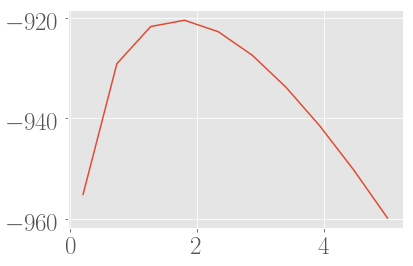

In [174]:
plt.plot(tau_list,ll_list)

In [175]:
ll_list= np.array(ll_list)
ll_list.max()

-920.5020027385556

In [176]:
(np.argwhere(ll_list == max(ll_list))[0][0], tau_list[np.argwhere(ll_list == max(ll_list))][0][0])

(3, 1.8)

In [177]:
tau = tau_list[np.argwhere(ll_list == max(ll_list))][0][0]

In [178]:
24*delta_t*tau

1.8

In [179]:
times = np.cumsum(strain_total_freqs["Date_Diffs"])

In [180]:
#strain = 2
#sigma = (2/(1/.17+1))**2
#sigma = 0.43
#sigma = 0.2948303412538197
#sigma = 0.40486724722627987
#K = np.trapz(strain_total_freqs[strain],strain_total_freqs["ate_Diffs"])/(1-(sigma/2))
#N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))
#K = sum(strain_total_freqs[strain]*strain_total_freqs["Date_Diffs"])/N
#K = K/(1-sigma/2)
#delta_t = 1/24
#tau = tau_list[np.argwhere(ll_list == max(ll_list))][0][0]
#sigma = (1/np.sqrt(delta_t))*sigma

In [181]:
Yt

array([[0.00000000e+000, 7.91675847e-003, 8.96581658e-003, ...,
        2.60450368e-310, 2.63472320e-310, 2.66529335e-310],
       [0.00000000e+000, 7.88795043e-003, 8.93330851e-003, ...,
        2.60414982e-310, 2.63436524e-310, 2.66493123e-310],
       [0.00000000e+000, 7.85548236e-003, 8.89666947e-003, ...,
        2.60375103e-310, 2.63396182e-310, 2.66452313e-310],
       ...,
       [0.00000000e+000, 9.41074133e-007, 1.06836685e-006, ...,
        7.08524191e-148, 1.04844404e-149, 1.47650111e-151],
       [0.00000000e+000, 1.01267140e-006, 1.14964856e-006, ...,
        5.87715443e-148, 8.69580184e-150, 1.22447637e-151],
       [0.00000000e+000, 1.08526937e-006, 1.23206634e-006, ...,
        4.87925249e-148, 7.21851119e-150, 1.01634350e-151]])

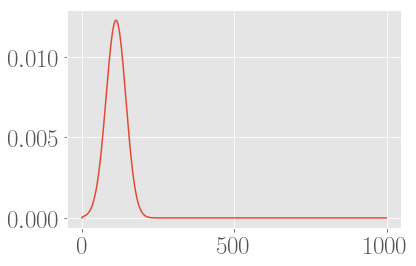

In [182]:
plt.plot(Yt[100,:])

In [183]:
@jit
def conditional_prob(xt,sigma,tau,K,xrange,delta_t):
    
    mu = xt + (xt/tau*(1-xt/K) * delta_t)
    std = np.sqrt(sigma/tau) * xt * np.sqrt(delta_t)
    
    cond_prob = []
    
    for xval in xrange:
        cond_prob.append((1/std)*np.exp(-1/2*((xval - mu)/std)**2))
    
    return(cond_prob)

In [184]:
#@jit
def matrix_power_table(date_diff_set,Y):
    
    YT_dic = {1:Y}
    num = 1
    for diff in date_diff_set:
        YT_temp = YT_dic[num]
        #num = diff + num
        YT_dic[diff] = np.linalg.matrix_power(YT_temp,diff)
    return YT_dic

In [185]:
dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])

In [186]:
Y = []
#xrange = np.logspace(np.log10(1e-7),np.log10(1),500)
#xrange_diff = (xrange[1:] - xrange[:-1])
#xrange_diff = np.insert(xrange_diff,0,xrange[0])

for xt in xrange:
    y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
    y = np.array(y)
    y = y/np.sqrt(2*np.pi)
    
    Y.append(y)

#Y = np.array(Y)

for i in range(len(Y)):
    
    Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
    Y = np.nan_to_num(Y,0)
    Y[i] = np.array(Y[i])*xrange_diff
    Y[i] = Y[i,:]/sum(Y[i,:])
    #Y[i] = Y[i,:]/trapz(Y[i,:],xrange)
#Y = np.insert(Y,0,0,axis=0)
#Y[0][0] = 1
Y = np.linalg.matrix_power(Y,int(1/delta_t))

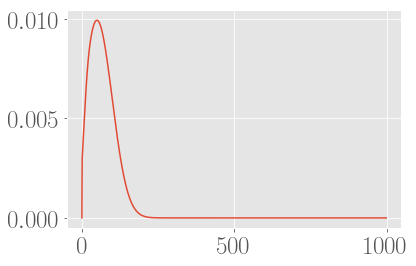

In [187]:
plt.plot(Y[10,:])

In [188]:
# Y[0]

In [189]:
t1 = time.time()
dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])
#dd_diff_set = list(dd_set[1:] - dd_set[:-1])
YT_l = matrix_power_table(dd_set,Y)
t2 = time.time()

In [190]:
bin_list = []
for elem in strain_total_freqs[strain]:
    diffarr = np.abs(elem - xrange) 
    bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
bin_list = np.array(bin_list)

1


[]

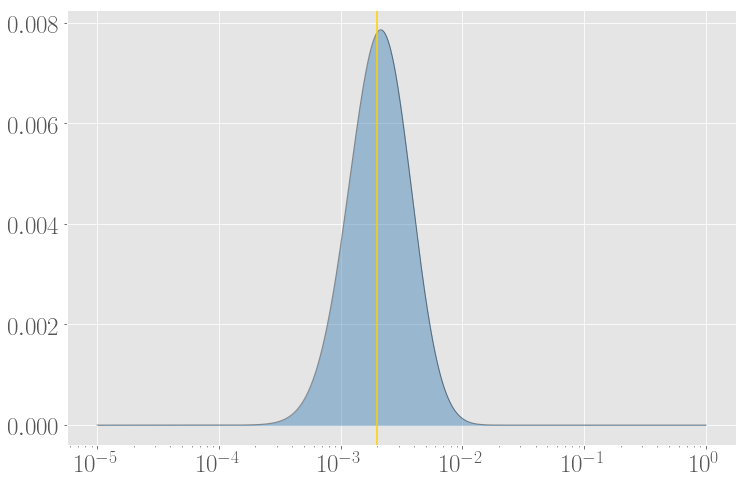

In [ ]:
i = 4
fig, ax = plt.subplots(figsize=(12,8))

date_diff = int(strain_total_freqs.iloc[i+1]["Date_Diffs"])
print(date_diff)
#Yt = Y[bin_list[i],:]
#Yt = np.linalg.matrix_power(Y,date_diff)
Yt = YT_l[date_diff]
## color="#FFD100"
ax.plot(xrange,Yt[bin_list[i],:],linewidth=1,color="k",alpha=.4)
ax.fill_between(xrange, 0, Yt[bin_list[i],:],color="#2774AE",alpha=.4)

#ax.plot(xrange,Yt,linewidth=1,color="k",alpha=.4)
#ax.fill_between(xrange, 0, Yt,color="#2774AE",alpha=.4)

ax.axvline(xrange[bin_list[i+1]],color="#FFD100")

ax.semilogx()

#ax.set_xlim([0,1e-2])

In [ ]:
Q = YT_l[1]
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real
stationary[stationary <= 0] = 0

In [ ]:
perc = .1/2

lklhds = [stationary[bin_list[0]]]
CI = {}

lower = np.argwhere(np.abs(np.cumsum(stationary) - perc) == min(np.abs(np.cumsum(stationary) - perc)))[0][0]
upper = np.argwhere(np.abs(np.cumsum(stationary) - (1-perc)) == min(np.abs(np.cumsum(stationary) - (1-perc))))[0][0]
CI[0] = (xrange[lower],xrange[upper])

#CI = {}
strain_total_freqs.index = strain_total_freqs["Order"]
for i in strain_total_freqs["Order"][:-1]:
    date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
    Yt = YT_l[date_diff]
    #Yt = np.linalg.matrix_power(Y,int(date_diff))
    lklhds.append(Yt[bin_list[i],bin_list[i+1]])
    lower = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc)))[0][0]
    upper = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc)) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc))))[0][0]
    CI[i + 1] = (xrange[lower],xrange[upper])

In [ ]:
lklhds = np.array(lklhds)
data_ll = sum(np.log(lklhds))

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


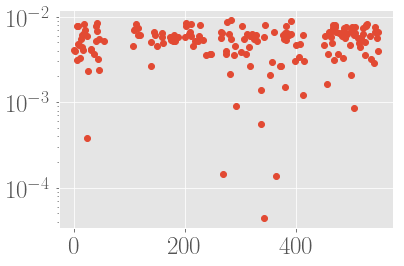

In [ ]:
times = np.cumsum(strain_total_freqs["Date_Diffs"])
plt.plot(times,lklhds,'o')
plt.yscale("log")

In [ ]:
CI_vals = np.array(list(CI.values()))

In [ ]:
CI_df = pd.DataFrame(CI,index=["lower","upper"]).T

In [ ]:
CI_df = pd.DataFrame(CI,index=["lower","upper"]).T
CI_df["strain"] = strain_total_freqs[strain]

good_fits = CI_df.loc[np.logical_and(CI_df["strain"] > CI_df["lower"], CI_df["strain"] < CI_df["upper"])].index

good_fits = np.array(list(good_fits))

In [ ]:
len(good_fits)/strain_total_freqs.shape[0]

0.936046511627907

In [ ]:
sum(np.log(lklhds))

-926.000504532931

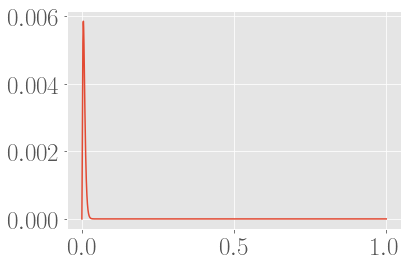

In [ ]:
plt.plot(xrange,stationary)

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Attempted to set non-positive bottom ylim

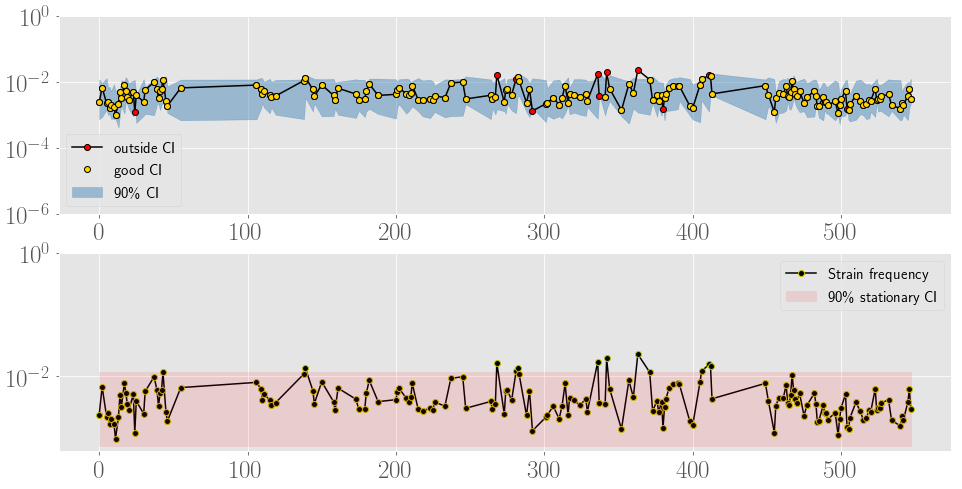

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(16,8))

axs[0].fill_between(times,CI_vals[:,0], CI_vals[:,1], color="#2774AE", alpha=.4,label=f"{int(100*(1-2*perc))}\% CI",zorder=1)

axs[0].plot(times,strain_total_freqs[strain], 'o-',color="k",
        label="outside CI",markeredgecolor='k',markerfacecolor="red",zorder=2)
axs[0].plot(times[good_fits],np.array(strain_total_freqs[strain])[good_fits], 'o',color="k",
        label="good CI",markeredgecolor='k',markerfacecolor="#FFD100",zorder=2)

axs[0].semilogy()
axs[0].legend()
axs[0].set_ylim([1e-6,1e0])

axs[1].plot(times,strain_total_freqs[strain], 'o-',color="k",
        label="Strain frequency",markeredgecolor='y',markerfacecolor="k",zorder=1)

axs[1].fill_between(times,CI_vals[0,0], CI_vals[0,1],color='r',alpha=.1,zorder=2,label=f"{int(100*(1-2*perc))}\% stationary CI")

axs[1].semilogy()

axs[1].set_ylim([0,1e0])

axs[1].legend()

In [ ]:
P = []
for i in range(int(max(times))):
    P.append(list(stationary))
P = np.array(P).T

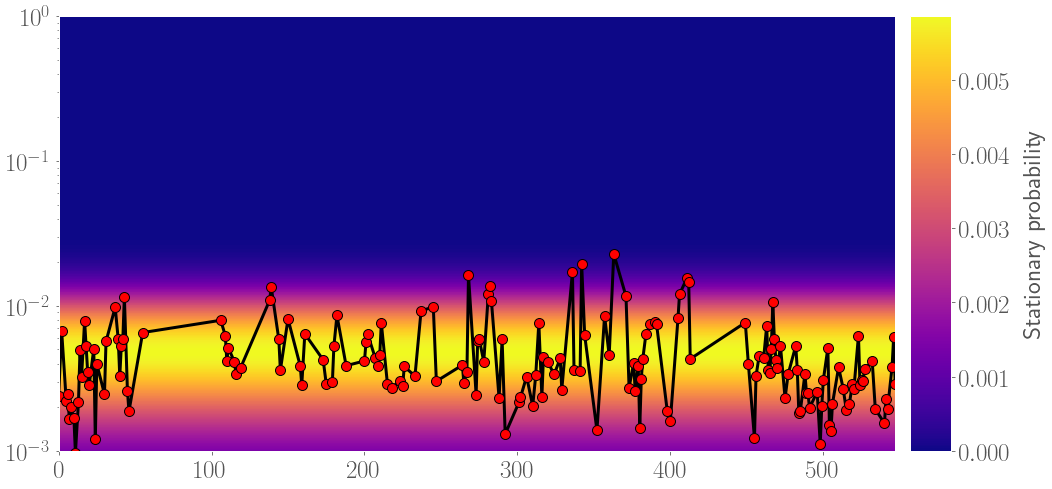

In [ ]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

P = []
for i in range(int(max(times))):
    P.append(list(stationary))
P = np.array(P).T

side = np.linspace(0,max(times),max(times))
X,Y = np.meshgrid(side,xrange)

fig, ax = plt.subplots(1,figsize=(16,8))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

im = ax.pcolormesh(X,Y,P,cmap=plt.cm.plasma)
ax.semilogy()

ax.plot(times,strain_total_freqs[strain], 'o-',color="k",
        label="Strain frequency",markeredgecolor='k',markerfacecolor="r",zorder=1,lw=3,markersize=10)

ax.set_ylim([1e-3,1])

cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Stationary probability',size=25,labelpad=10)

In [ ]:
date_diff = np.array(list(strain_total_freqs["Date_Diffs"]))

In [ ]:
def sim_SLM_MC(YT_dic,xrange,stationary,date_diff):
    
    x0 = np.random.choice(xrange,p=stationary)
    
    diffarr = np.abs(xrange - x0) 
    X = [xrange[np.argwhere(diffarr == min(diffarr))[0][0]]]    
    N = len(date_diff)
    for i in range(N-1):
        dd = date_diff[i+1]
        Yt = YT_dic[dd]
        x = X[-1]
        diffarr = np.abs(xrange - x) 
        argw = np.argmin(diffarr)
        #argw = np.argwhere(diffarr == min(diffarr))[0][0]
        
        X.append(np.random.choice(xrange,p=Yt[argw]))
        
    return X

In [ ]:
#x0 = strain_total_freqs.iloc[0][strain]
x0 = np.random.choice(xrange,p=stationary)
N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))

X_list = []

for i in range(int(1e3)):
    X_list.append(sim_SLM_MC(YT_l,xrange,stationary,date_diff))

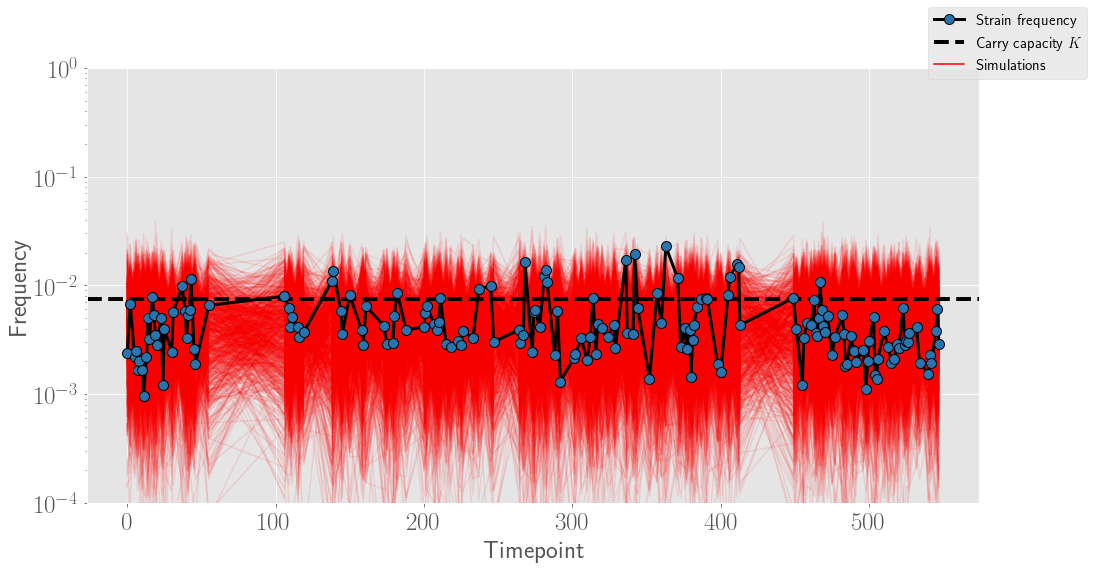

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

fig,ax = plt.subplots(figsize=(16,8))

for i in range(int(1e3)):
    
    ax.plot(times,X_list[i],alpha=.1,color="red",zorder=1,label=None)

ax.plot(times,strain_total_freqs[strain], 'o-',color="k",
        label="Strain frequency",markeredgecolor='k',markerfacecolor="#2774AE",zorder=2,lw=3,
        markersize=10)

ax.axhline(K,color="k",lw = 4,label=r"Carry capacity $K$",linestyle="--",zorder=1)

handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label = 'Simulations',color='red')

handles.extend([line])

ax.set_ylim([1e-4,1])

ax.set_yscale("log")

ax.set_ylabel("Frequency",size=25)

ax.set_xlabel("Timepoint",size=25)

fig.legend(handles=handles);

In [ ]:
ll_list = []
for X_run in X_list:
    
    bin_list = []
    
    for xi in X_run:
        diffarr = np.abs(xi - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)
    lklhds = []

    for i in range(len(X_run) - 1):
        dd = date_diff[i+1]
        Yt = YT_l[dd]
        #Yt = np.linalg.matrix_power(Y,int(date_diff))
    
        lklhds.append(Yt[bin_list[i],bin_list[i+1]])
    
    lklhds = np.array(lklhds)
    ll_list.append(np.sum(np.log(lklhds)))

In [ ]:
fig_ll, ax_ll = plt.subplots(figsize=(6,4))
fig_ll.suptitle(figure_utils.get_pretty_species_name(species),size=15)

ax_ll.hist(ll_list,density=True,bins=30,label="Simulations",ec="k")

ax_ll.axvline(data_ll,color="k",linestyle="--",linewidth=3,label="Observed");
fig_ll.legend()

ax_ll.set_ylabel("Density",size=25)
ax_ll.set_xlabel("Log-likelihood",size=25)

fig_ll.savefig(f"{config.analysis_directory}/final_paper_figures/B_vulg_loglik.png")

In [ ]:
np.logical_and(data_ll >= np.percentile(ll_list,5),data_ll <= np.percentile(ll_list,95))

In [172]:
sum(1*(data_ll > ll_list)/len(ll_list))

0.9930000000000008

In [ ]:
beta

In [ ]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(2,1,figsize=(16,8))

fig.suptitle(figure_utils.get_pretty_species_name(species),size=30)

axs[0].fill_between(times,CI_vals[:,0], CI_vals[:,1], color="#2774AE", alpha=.4,label=f"{int(100*(1-2*perc))}\% CI",zorder=1)

axs[0].plot(times,strain_total_freqs[strain], 'o-',color="k",
        label="outside CI",markeredgecolor='k',markerfacecolor="red",zorder=2)
axs[0].plot(times[good_fits],np.array(strain_total_freqs[strain])[good_fits], 'o',color="k",
        label="within CI",markeredgecolor='k',markerfacecolor="#FFD100",zorder=2)

axs[0].semilogy()
axs[0].legend()
axs[0].set_ylim([1e-4,1e0])
axs[0].set_ylabel("Frequency",size=25)

for i in range(int(1e3)):
    
    axs[1].plot(times,X_list[i],alpha=.1,color="red",zorder=1,label=None)

axs[1].plot(times,strain_total_freqs[strain], 'o-',color="k",
        label="Strain frequency",markeredgecolor='k',markerfacecolor="#2774AE",zorder=2,lw=3,
        markersize=7.5)

axs[1].axhline(K,color="k",lw = 4,label=r"Carrying capacity $K$",linestyle="--",zorder=1)

handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label = 'Simulations',color='red')

handles.extend([line])

axs[1].set_ylim([1e-4,1])

axs[1].set_yscale("log")

axs[1].set_ylabel("Frequency",size=25)

axs[1].set_xlabel("Timepoint",size=25)

axs[1].legend(handles=handles,loc="upper right");

fig.savefig(f"{config.analysis_directory}/final_paper_figures/F_prau_timeseries.png")

In [ ]:
rel_ab = pd.read_csv("/u/scratch/r/rwolff/merged_MIDAS_output/%s/species/relative_abundance.txt" % host,sep="\t",index_col=0)

In [ ]:
psamps = config.Poyet_samples[host]

In [ ]:
rel_ab[psamps].T.mean().sort_values(ascending=False)[:30].index[2]

In [ ]:
sorted_species = rel_ab[psamps].T.mean().sort_values(ascending=False)
sorted_species[sorted_species > 5*1e-3]

In [ ]:
np.percentile(ll_list,5)

In [ ]:
import plot_SLM_trajectories

In [ ]:
import os

In [ ]:
plot_SLM_trajectories.run_SLM()

In [ ]:
subprocess.call(["python","/u/home/r/rwolff/diversity_ecology/scripts/plot_SLM_trajectories.py"])

In [ ]:
os.system("python3 plot_SLM_trajectories.py Bacteroides_vulgatus_57955 am")

In [ ]:
import subprocess

In [ ]:
x0 = strain_total_freqs.iloc[0][strain]
N = int(max(list(np.cumsum(strain_df["Date_Diffs"]))))

X_list = []

for i in range(int(1e2)):
    X_list.append(sim_SLM_MC())

In [ ]:
fig,ax = plt.subplots(figsize=(16,8))

for i in range(100):
    
    ax.plot(np.linspace(0,N,int(1/delta_t*N + 1)),X_list[i],alpha=.05,color="red",zorder=1)

ax.plot(times,strain_total_freqs[strain],color="k",linewidth=1)
ax.scatter(times,strain_total_freqs[strain],s=50,color="k",edgecolor="k",zorder=2)

ax.set_ylim([1e-5,1])

ax.set_yscale("log");

## Deprecated

In [ ]:
x0 = strain_total_freqs.iloc[0][strain]
delta_t = 1
#tau = 19/24
N = int(max(list(np.cumsum(strain_df["Date_Diffs"]))))
N = int(max(list(np.cumsum(strain_df["Date_Diffs"]))))
nse = stats.norm.rvs(size=int(1/delta_t)*N)

x_list = []
for i in range(int(1e3)):
    nse = stats.norm.rvs(size=(int(1/delta_t)*N))
    x = SLM(x0,tau,sigma,K,N,nse,delta_t)
    x_list.append(x)
    
fig,ax = plt.subplots(figsize=(16,8))

for i in range(500):
    
    ax.plot(np.linspace(0,N,int(1/delta_t*N + 1)),x_list[i],alpha=.01,color="red",zorder=1)
    
ax.plot(times,strain_total_freqs[strain],color="k",linewidth=1)
ax.scatter(times,strain_total_freqs[strain],s=50,color="k",edgecolor="k",zorder=2)

ax.set_ylim([1e-5,1])



In [ ]:
@jit
def SLM(x_0,tau,sgm,K,N,nse,delta_t):
     
    X = [x_0]
    
    for i in range(int(1/delta_t)*N):
        
        X_t = X[-1]
        
        X_t += ((X_t/tau)*(1 - X_t/K) + np.sqrt((1/delta_t)*sgm/tau)*X_t*nse[i])*(delta_t)
        
        if X_t < 0:
            X_t = 1e-6
            
        elif X_t > 1:
            X_t = 1-1e-6
        
        X.append(X_t)    
    
    return(X)

In [ ]:
species = "Bacteroides_vulgatus_57955"
host = "am"
anal_dir = config.analysis_directory
import os

In [ ]:

@jit
def conditional_prob(xt,sigma,tau,K,xrange,delta_t):
    
    mu = xt + xt/tau*(1-xt/K) * delta_t
    std = np.sqrt(sigma/tau) * xt * delta_t
    
    cond_prob = []
    
    for xval in xrange:
        cond_prob.append((1/std)*np.exp(-1/2*((xval - mu)/std)**2))
    
    return(cond_prob)
    
def matrix_power_table(date_diff_set,Y):
    
    YT_dic = {1:Y}
    num = 1
    
    for diff in date_diff_set:
        YT_temp = YT_dic[num]
        YT_dic[diff] = np.linalg.matrix_power(YT_temp,diff)
    
    return YT_dic
    

def sim_SLM_MC(YT_dic,x0,xrange):
    
    diffarr = np.abs(xrange - x0) 
    X = [xrange[np.argwhere(diffarr == min(diffarr))[0][0]]]    
    
    for i in strain_total_freqs["Order"][:-1]:
        date_diff = strain_total_freqs.iloc[i+1]["Date_Diffs"]
        Yt = YT_dic[date_diff]
        x = X[-1]
        diffarr = np.abs(xrange - x) 
        argw = np.argwhere(diffarr == min(diffarr))[0][0]
        
        X.append(np.random.choice(xrange,p=Yt[argw]))
        
    return X


In [ ]:
strain_total_freqs = pcu.get_strain_total_freqs(species,host)
strain_total_freqs.index = strain_total_freqs["Order"]

#good_species = config.good_species

#species = good_species[host][species_num]

path = f"{anal_dir}SLM_trajectory_figures/{host}/{species}"
os.makedirs(path, exist_ok=True)

#sigma = (2/(1/.17+1))
delta_t = 1/16
#sigma = (1/np.sqrt(delta_t))*sigma
dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])
times = np.cumsum(strain_total_freqs["Date_Diffs"])

for strain in [1,2,3]:
    
    sigma = (2/(1/.17+1))
    N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))
    K = sum(strain_total_freqs[strain]*strain_total_freqs["Date_Diffs"])/N

    K = K/(1-sigma/2)
    sigma = (1/np.sqrt(delta_t))*sigma
    dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])

    tau_list = np.linspace(1,6,50)

    bin_list = []

    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])
    
    for elem in strain_total_freqs[strain]:
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)

    ll_list = []

    for tau2 in tau_list:
    
        Y = []

        for xt in xrange:
            y = conditional_prob(xt,sigma,tau2,K,xrange,delta_t)
            y = np.array(y)
            y = y/np.sqrt(2*np.pi)
    
            Y.append(y)

        Y = np.array(Y)
     
        for i in range(Y.shape[0]):
    
            Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
            Y[i] = Y[i]*xrange_diff
            Y[i] = Y[i,:]/sum(Y[i,:])
    
        Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
        YT_l = matrix_power_table(dd_set,Y)
    
        lklhds = []

        for i in strain_total_freqs["Order"][:-1]:
            date_diff = strain_total_freqs.iloc[i+1]["Date_Diffs"]
            Yt = YT_l[date_diff]
            lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        
        ll_list.append(sum(np.log(lklhds)))
    
    tau = tau_list[np.argwhere(ll_list == max(ll_list))][0][0]
    char_timescale = 24*delta_t*tau
    
    ## now, calculate SLM markov matrix Y
    Y = []
    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])

    for xt in xrange:
        
        y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)

    for i in range(Y.shape[0]):
    
        Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
        Y[i] = Y[i]*xrange_diff
        Y[i] = Y[i,:]/sum(Y[i,:])
    
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    YT_l = matrix_power_table(dd_set,Y)
    
    bin_list = []
    
    for elem in strain_total_freqs[strain]:
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)
    
    lklhds = []
    CI = {}
    ## 90% confidence interval
    perc = .1/2
    strain_total_freqs.index = strain_total_freqs["Order"]
    
    for i in strain_total_freqs["Order"][:-1]:
        date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
        Yt = YT_l[date_diff]
    #Yt = np.linalg.matrix_power(Y,int(date_diff))
        lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        lower = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc)))[0][0]
        upper = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc)) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc))))[0][0]
        CI[i + 1] = (xrange[lower],xrange[upper])
    
    data_ll = sum(np.log(lklhds))
    CI_vals = np.array(list(CI.values()))
    CI_df = pd.DataFrame(CI,index=["lower","upper"]).T
    CI_df["strain"] = strain_total_freqs[strain]

    good_fits = CI_df.loc[np.logical_and(CI_df["strain"] > CI_df["lower"], CI_df["strain"] < CI_df["upper"])].index

    good_fits = np.array(list(good_fits))
    
    ## plot confidence interval figure
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(times[1:],strain_total_freqs[strain][1:], 'o-',color="k",
        label="bad fit",markeredgecolor='k',markerfacecolor="red",zorder=2)
    ax.plot(times[good_fits],np.array(strain_total_freqs[strain])[good_fits], 'o',color="k",
        label="good fit",markeredgecolor='k',markerfacecolor="#FFD100",zorder=2)
    ax.fill_between(times[1:],CI_vals[:,0], CI_vals[:,1], color="#2774AE", alpha=.4,label=f"{100*(1-2*perc)}\% confidence interval",zorder=1)

    ax.semilogy()
    
    fig.legend()
    fig.savefig(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_CI_trajectory.png")
                
    x0 = strain_total_freqs.iloc[0][strain]

    X_list = []

    ## run 1000 replicates of MC 
    for i in range(int(1e3)):
        X_list.append(sim_SLM_MC(YT_l,x0,xrange))

    fig_sim,ax_sim = plt.subplots(figsize=(16,8))

    for i in range(int(1e3)):
    
        ax_sim.plot(times,X_list[i],alpha=.05,color="red",zorder=1)
    
    ax_sim.plot(times,strain_total_freqs[strain],color="k",linewidth=1)
    ax_sim.scatter(times,strain_total_freqs[strain],s=50,color="k",edgecolor="k",zorder=2)

    ax_sim.set_ylim([1e-5,1])

    ax_sim.set_yscale("log");           
                
    fig_sim.savefig(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_simulations.png")
    
    ## retrieve log-likelihood associated with each simulated trajectory
    X_df = pd.DataFrame(X_list)

    ll_list = []
    
    for k in X_df.index:
        
        bin_list = []
        for elem in X_df.loc[k]:
            diffarr = np.abs(elem - xrange) 
            bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
            
        bin_list = np.array(bin_list)
        lklhds = []

        for i in X_df.columns[:-1]:
            date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
            Yt = YT_l[date_diff]
    
            lklhds.append(Yt[bin_list[i],bin_list[i+1]])
    
        lklhds = np.array(lklhds)
        ll_list.append(np.sum(np.log(lklhds)))
    
    fig_ll, ax_ll = plt.subplots(figsize=(6,4))
    ax_ll.hist(ll_list,density=True,bins=30,label="Simulations")

    ax_ll.axvline(data_ll,color="k",linestyle="--",linewidth=3,label="Observed");
    fig_ll.legend()
    
    pval_test = np.logical_and(data_ll >= np.percentile(ll_list,5),data_ll <= np.percentile(ll_list,95))
    
    out_dic = {"pval_test":pval_test,"tau":tau,"characteristic_timescale":char_timescale}
    
    with open(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_out_dic.pkl","wb") as f:
        pickle.dump(out_dic,f,protocol=2)
    
    sys.stderr.write(f"{species} strain {strain} finished \n")

In [ ]:
tau

In [ ]:
pval_test

In [ ]:
sigma

In [ ]:
sigma/4

In [ ]:
#sigma = (2/(1/.17+1))
delta_t = 1/16
#sigma = (1/np.sqrt(delta_t))*sigma
dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])
times = np.cumsum(strain_total_freqs["Date_Diffs"])

for strain in [3]:
    sigma = (2/(1/.17+1))

    N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))
    K = sum(strain_total_freqs[strain]*strain_total_freqs["Date_Diffs"])/N

    K = K/(1-sigma/2)
    sigma = (1/np.sqrt(delta_t))*sigma

    dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])

    tau_list = np.linspace(1,6,50)

    bin_list = []

    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])
    
    for elem in strain_total_freqs[strain]:
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)

    ll_list = []

    for tau2 in tau_list:
    
        Y = []

        for xt in xrange:
            y = conditional_prob(xt,sigma,tau2,K,xrange,delta_t)
            y = np.array(y)
            y = y/np.sqrt(2*np.pi)
    
            Y.append(y)

        Y = np.array(Y)
     
        for i in range(Y.shape[0]):
    
            Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
            Y[i] = Y[i]*xrange_diff
            Y[i] = Y[i,:]/sum(Y[i,:])
    
        Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
        YT_l = matrix_power_table(dd_set,Y)
    
        lklhds = []

        for i in strain_total_freqs["Order"][:-1]:
            date_diff = strain_total_freqs.iloc[i+1]["Date_Diffs"]
            Yt = YT_l[date_diff]
            lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        
        ll_list.append(sum(np.log(lklhds)))
    
    tau = tau_list[np.argwhere(ll_list == max(ll_list))][0][0]
    char_timescale = 24*delta_t*tau
    
    ## now, calculate SLM markov matrix Y
    Y = []
    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])

    for xt in xrange:
        
        y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)

    for i in range(Y.shape[0]):
    
        Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
        Y[i] = Y[i]*xrange_diff
        Y[i] = Y[i,:]/sum(Y[i,:])
    
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    YT_l = matrix_power_table(dd_set,Y)
    
    bin_list = []
    
    for elem in strain_total_freqs[strain]:
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)
    
    lklhds = []
    CI = {}
    ## 90% confidence interval
    perc = .1/2
    strain_total_freqs.index = strain_total_freqs["Order"]
    
    for i in strain_total_freqs["Order"][:-1]:
        date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
        Yt = YT_l[date_diff]
    #Yt = np.linalg.matrix_power(Y,int(date_diff))
        lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        lower = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc)))[0][0]
        upper = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc)) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc))))[0][0]
        CI[i + 1] = (xrange[lower],xrange[upper])
    
    data_ll = sum(np.log(lklhds))
    CI_vals = np.array(list(CI.values()))
    CI_df = pd.DataFrame(CI,index=["lower","upper"]).T
    CI_df["strain"] = strain_total_freqs[strain]

    good_fits = CI_df.loc[np.logical_and(CI_df["strain"] > CI_df["lower"], CI_df["strain"] < CI_df["upper"])].index

    good_fits = np.array(list(good_fits))
    
    ## plot confidence interval figure
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(times[1:],strain_total_freqs[strain][1:], 'o-',color="k",
        label="bad fit",markeredgecolor='k',markerfacecolor="red",zorder=2)
    ax.plot(times[good_fits],np.array(strain_total_freqs[strain])[good_fits], 'o',color="k",
        label="good fit",markeredgecolor='k',markerfacecolor="#FFD100",zorder=2)
    ax.fill_between(times[1:],CI_vals[:,0], CI_vals[:,1], color="#2774AE", alpha=.4,label=f"{100*(1-2*perc)}\% confidence interval",zorder=1)

    ax.semilogy()
    
    fig.legend()
    fig.savefig(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_CI_trajectory.png")

In [ ]:
strain_total_freqs = pcu.get_strain_total_freqs(species,host)


In [ ]:
plt.plot(tau_list,ll_list)

In [ ]:
(np.argwhere(ll_list == max(ll_list))[0][0], tau_list[np.argwhere(ll_list == max(ll_list))][0][0])

In [ ]:
#species_num = int(sys.argv[1])
species_num = 2
#host = sys.argv[2]
host = "am"
#strain_total_freqs = pcu.get_strain_total_freqs(species,host)

good_species = config.good_species
species = good_species[host][species_num]
sys.stderr.write(f"{species} {host} \n")

In [ ]:
anal_dir = config.analysis_directory

#species_num = int(sys.argv[1])
species_num = 2
#host = sys.argv[2]
host = "am"
#strain_total_freqs = pcu.get_strain_total_freqs(species,host)

good_species = config.good_species
species = good_species[host][species_num]
sys.stderr.write(f"{species} {host} \n")

path = f"{anal_dir}SLM_trajectory_figures/{host}/{species}"

os.makedirs(path, exist_ok=True)

@jit
def conditional_prob(xt,sigma,tau,K,xrange,delta_t):
    
    mu = xt + xt/tau*(1-xt/K) * delta_t
    std = np.sqrt(sigma/tau) * xt * delta_t
    
    cond_prob = []
    
    for xval in xrange:
        cond_prob.append((1/std)*np.exp(-1/2*((xval - mu)/std)**2))
    
    return(cond_prob)
    
def matrix_power_table(date_diff_set,Y):
    
    YT_dic = {1:Y}
    num = 1
    for diff in date_diff_set:
        YT_temp = YT_dic[num]
        YT_dic[diff] = np.linalg.matrix_power(YT_temp,diff)
    return YT_dic
    

def sim_SLM_MC(YT_dic,x0,xrange):
    
    diffarr = np.abs(xrange - x0) 
    X = [xrange[np.argwhere(diffarr == min(diffarr))[0][0]]]    
    
    for i in strain_total_freqs["Order"][:-1]:
        date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
        Yt = YT_dic[date_diff]
        x = X[-1]
        diffarr = np.abs(xrange - x) 
        argw = np.argwhere(diffarr == min(diffarr))[0][0]
        
        X.append(np.random.choice(xrange,p=Yt[argw]))
        
    return X

strain_total_freqs = pcu.get_strain_total_freqs(species,host)
strain_total_freqs.index = strain_total_freqs["Order"]

path = f"{anal_dir}SLM_trajectory_figures/{host}/{species}"
os.makedirs(path, exist_ok=True)

delta_t = 1/16
dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])
times = np.cumsum(strain_total_freqs["Date_Diffs"])

for strain in strain_total_freqs[:-2]:
    
    sigma = (2/(1/.17+1))
    N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))
    K = sum(strain_total_freqs[strain]*strain_total_freqs["Date_Diffs"])/N

    K = K/(1-sigma/2)
    sigma = (1/np.sqrt(delta_t))*sigma
    
    dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])

    tau_list = np.linspace(1,6,50)

    bin_list = []

    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])
    
    for elem in strain_total_freqs[strain]:
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)

    ll_list = []

    for tau2 in tau_list:
    
        Y = []

        for xt in xrange:
            y = conditional_prob(xt,sigma,tau2,K,xrange,delta_t)
            y = np.array(y)
            y = y/np.sqrt(2*np.pi)
    
            Y.append(y)

        Y = np.array(Y)
     
        for i in range(Y.shape[0]):
    
            Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
            Y[i] = Y[i]*xrange_diff
            Y[i] = Y[i,:]/sum(Y[i,:])
    
        Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
        YT_l = matrix_power_table(dd_set,Y)
    
        lklhds = []

        for i in strain_total_freqs["Order"][:-1]:
            date_diff = strain_total_freqs.iloc[i+1]["Date_Diffs"]
            Yt = YT_l[date_diff]
            lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        
        ll_list.append(sum(np.log(lklhds)))
    
    tau = tau_list[np.argwhere(ll_list == max(ll_list))][0][0]
    char_timescale = 24*delta_t*tau
    
    ## now, calculate SLM markov matrix Y
    Y = []
    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])

    for xt in xrange:
        
        y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)

    for i in range(Y.shape[0]):
    
        Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
        Y[i] = Y[i]*xrange_diff
        Y[i] = Y[i,:]/sum(Y[i,:])
    
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    YT_l = matrix_power_table(dd_set,Y)
    
    bin_list = []
    
    for elem in strain_total_freqs[strain]:
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)
    
    lklhds = []
    CI = {}
    ## 90% confidence interval
    perc = .1/2
    strain_total_freqs.index = strain_total_freqs["Order"]
    
    for i in strain_total_freqs["Order"][:-1]:
        date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
        Yt = YT_l[date_diff]
    #Yt = np.linalg.matrix_power(Y,int(date_diff))
        lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        lower = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc)))[0][0]
        upper = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc)) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc))))[0][0]
        CI[i + 1] = (xrange[lower],xrange[upper])
    
    data_ll = sum(np.log(lklhds))
    CI_vals = np.array(list(CI.values()))
    CI_df = pd.DataFrame(CI,index=["lower","upper"]).T
    CI_df["strain"] = strain_total_freqs[strain]

    good_fits = CI_df.loc[np.logical_and(CI_df["strain"] > CI_df["lower"], CI_df["strain"] < CI_df["upper"])].index

    good_fits = np.array(list(good_fits))
    
    ## plot confidence interval figure
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(times[1:],strain_total_freqs[strain][1:], 'o-',color="k",
        label="bad fit",markeredgecolor='k',markerfacecolor="red",zorder=2)
    ax.plot(times[good_fits],np.array(strain_total_freqs[strain])[good_fits], 'o',color="k",
        label="good fit",markeredgecolor='k',markerfacecolor="#FFD100",zorder=2)
    ax.fill_between(times[1:],CI_vals[:,0], CI_vals[:,1], color="#2774AE", alpha=.4,label=f"{100*(1-2*perc)}\% confidence interval",zorder=1)

    ax.semilogy()
    
    fig.legend()
    fig.savefig(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_CI_trajectory.png")
                
    x0 = strain_total_freqs.iloc[0][strain]

    X_list = []

    ## run 1000 replicates of MC 
    for i in range(int(1e3)):
        X_list.append(sim_SLM_MC(YT_l,x0,xrange))

    fig_sim,ax_sim = plt.subplots(figsize=(16,8))

    for i in range(int(1e3)):
    
        ax_sim.plot(times,X_list[i],alpha=.05,color="red",zorder=1)
    
    ax_sim.plot(times,strain_total_freqs[strain],color="k",linewidth=1)
    ax_sim.scatter(times,strain_total_freqs[strain],s=50,color="k",edgecolor="k",zorder=2)

    ax_sim.set_ylim([1e-5,1])

    ax_sim.set_yscale("log");           
                
    fig_sim.savefig(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_simulations.png")
    
    ## retrieve log-likelihood associated with each simulated trajectory
    X_df = pd.DataFrame(X_list)

    ll_list = []
    
    for k in X_df.index:
        
        bin_list = []
        for elem in X_df.loc[k]:
            diffarr = np.abs(elem - xrange) 
            bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
            
        bin_list = np.array(bin_list)
        lklhds = []

        for i in X_df.columns[:-1]:
            date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
            Yt = YT_l[date_diff]
    
            lklhds.append(Yt[bin_list[i],bin_list[i+1]])
    
        lklhds = np.array(lklhds)
        ll_list.append(np.sum(np.log(lklhds)))
    
    fig_ll, ax_ll = plt.subplots(figsize=(6,4))
    ax_ll.hist(ll_list,density=True,bins=30,label="Simulations")

    ax_ll.axvline(data_ll,color="k",linestyle="--",linewidth=3,label="Observed");
    fig_ll.legend()
    fig_ll.savefig(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_loglik.png")
    
    pval_test = np.logical_and(data_ll >= np.percentile(ll_list,5),data_ll <= np.percentile(ll_list,95))
    
    
    out_dic = {"pval_test":pval_test,"tau":tau,"characteristic_timescale":char_timescale}
    
    with open(f"{anal_dir}SLM_trajectory_figures/{host}/{species}/{species}_{strain}_out_dic.pkl","wb") as f:
        pickle.dump(out_dic,f,protocol=2)
    
    sys.stderr.write(f"{species} strain {strain} finished \n")

In [ ]:
tau

In [ ]:
anal_dir = config.analysis_directory

#species_num = int(sys.argv[1])
species_num = 2
#host = sys.argv[2]
host = "am"
#strain_total_freqs = pcu.get_strain_total_freqs(species,host)

good_species = config.good_species
species = good_species[host][species_num]
sys.stderr.write(f"{species} {host} \n")

path = f"{anal_dir}SLM_trajectory_figures/{host}/{species}"

os.makedirs(path, exist_ok=True)

strain_total_freqs = pcu.get_strain_total_freqs(species,host)
strain_total_freqs.index = strain_total_freqs["Order"]

path = f"{anal_dir}SLM_trajectory_figures/{host}/{species}"
os.makedirs(path, exist_ok=True)

delta_t = 1/16
dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])
times = np.cumsum(strain_total_freqs["Date_Diffs"])
sigma_o = (2/(1/.17+1))
sigma = (1/np.sqrt(delta_t))*sigma_o

## strain_total_freqs.columns[:-2]
for strain in [1]:
    
    N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))
    xbar = sum(strain_total_freqs[strain]*strain_total_freqs["Date_Diffs"])/N

    K = xbar/(1-sigma_o/2)
        
    tau_list = np.linspace(1,6,50)

    bin_list = []

    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])
    
    for elem in strain_total_freqs[strain]:
        
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)

    ll_list = []

    for tau2 in tau_list:
        
        tau_Y = make_markov_matrix(sigma,tau2,K,xrange,delta_t)
        Yt_l = matrix_power_table(dd_set,tau_Y)
    
        lklhds = []

        for i in strain_total_freqs["Order"][:-1]:
            date_diff = strain_total_freqs.iloc[i+1]["Date_Diffs"]
            Yt = Yt_l[date_diff]
            lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        
        ll_list.append(sum(np.log(lklhds)))
    
    tau = tau_list[np.argwhere(ll_list == max(ll_list))][0][0]
    char_timescale = 24*delta_t*tau
    print(f"tau = {tau}")
    tau = 4
    ## now, calculate SLM markov matrix Y
    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])

    Y = make_markov_matrix(sigma,tau,K,xrange,delta_t)
    YT_l = matrix_power_table(dd_set,Y)
    
    bin_list = []
    
    for elem in strain_total_freqs[strain]:
        
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)
    
    lklhds = []
    CI = {}
    ## 90% confidence interval
    perc = .1/2
    strain_total_freqs.index = strain_total_freqs["Order"]
    
    for i in strain_total_freqs["Order"][:-1]:
        
        date_diff = strain_total_freqs.loc[i+1]["Date_Diffs"]
        Yt = YT_l[date_diff]
        lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        lower = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - perc)))[0][0]
        upper = np.argwhere(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc)) == min(np.abs(np.cumsum(Yt[bin_list[i],:]) - (1-perc))))[0][0]
        CI[i + 1] = (xrange[lower],xrange[upper])
    
    data_ll = sum(np.log(lklhds))
    CI_vals = np.array(list(CI.values()))
    CI_df = pd.DataFrame(CI,index=["lower","upper"]).T
    CI_df["strain"] = strain_total_freqs[strain]

    good_fits = CI_df.loc[np.logical_and(CI_df["strain"] > CI_df["lower"], CI_df["strain"] < CI_df["upper"])].index

    good_fits = np.array(list(good_fits))
    
    ## plot confidence interval figure
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(times[1:],strain_total_freqs[strain][1:], 'o-',color="k",
        label="bad fit",markeredgecolor='k',markerfacecolor="red",zorder=2)
    ax.plot(times[good_fits],np.array(strain_total_freqs[strain])[good_fits], 'o',color="k",
        label="good fit",markeredgecolor='k',markerfacecolor="#FFD100",zorder=2)
    ax.fill_between(times[1:],CI_vals[:,0], CI_vals[:,1], color="#2774AE", alpha=.4,label=f"{100*(1-2*perc)}\% confidence interval",zorder=1)

    ax.semilogy()
    
    fig.legend()

In [ ]:
sigma

In [ ]:
sigma_o

In [ ]:
K

In [ ]:
plt.plot(tau_list,ll_list)

In [ ]:
def make_markov_matrix(sigma,tau,K,xrange,delta_t):
    Y = []
    for xt in xrange:
        y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)
     
    for i in range(Y.shape[0]):
    
        Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
        Y[i] = Y[i]*xrange_diff
        Y[i] = Y[i,:]/sum(Y[i,:])
    
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
    return(Y)

In [ ]:
plt.plot(Yt[20,:])

In [ ]:
Yt = make_markov_matrix(xt,sigma,2.4,K,xrange,delta_t)

In [ ]:
anal_dir = config.analysis_directory

#species_num = int(sys.argv[1])
species_num = 2
#host = sys.argv[2]
host = "am"
#strain_total_freqs = pcu.get_strain_total_freqs(species,host)

good_species = config.good_species
species = good_species[host][species_num]
sys.stderr.write(f"{species} {host} \n")


strain_total_freqs = pcu.get_strain_total_freqs(species,host)
strain_total_freqs.index = strain_total_freqs["Order"]

#path = f"{anal_dir}SLM_trajectory_figures/{host}/{species}"
#os.makedirs(path, exist_ok=True)

delta_t = 1/16
dd_set = np.array(sorted(list(set(strain_total_freqs["Date_Diffs"])))[1:])
times = np.cumsum(strain_total_freqs["Date_Diffs"])
sigma_o = (2/(1/.17+1))
sigma = (1/np.sqrt(delta_t))*sigma_o

## strain_total_freqs.columns[:-2]
for strain in [1]:
    
    N = int(max(list(np.cumsum(strain_total_freqs["Date_Diffs"]))))
    xbar = sum(strain_total_freqs[strain]*strain_total_freqs["Date_Diffs"])/N

    K = xbar/(1-sigma_o/2)
        
    tau_list = np.linspace(1,6,50)

    bin_list = []

    xrange = np.logspace(np.log10(1e-5),np.log10(1),500)
    xrange_diff = (xrange[1:] - xrange[:-1])
    xrange_diff = np.insert(xrange_diff,0,xrange[0])
    
    for elem in strain_total_freqs[strain]:
        
        diffarr = np.abs(elem - xrange) 
        bin_list.append(np.argwhere(diffarr == min(diffarr))[0][0])
    
    bin_list = np.array(bin_list)

    ll_list = []

    for tau2 in tau_list:
        
        tau_Y = make_markov_matrix(sigma,tau2,K,xrange,delta_t)
        Yt_l = matrix_power_table(dd_set,tau_Y)
    
        lklhds = []

        for i in strain_total_freqs["Order"][:-1]:
            date_diff = strain_total_freqs.iloc[i+1]["Date_Diffs"]
            Yt = Yt_l[date_diff]
            lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        
        ll_list.append(sum(np.log(lklhds)))

In [ ]:
plt.plot(ll_list)